In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime

#For Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker 
from matplotlib.patches import Rectangle

#Stuff for Meteorological calculations 
import wrf
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
from scipy.ndimage import gaussian_filter

#to read in files
import glob
import pandas as pd

#for color scale
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, to_rgba
import matplotlib.patches as mpatches

In [3]:
#Function Below is for a storm following map projection. Credit: Dr. Sharanya Majumdar @The University of Miami
dataproj = ccrs.PlateCarree()

def create_map_background(tclon, tclat, ax=None):
    tclon5a = 5 * (int(tclon / 5) - 1)
    tclon5b = 5 * (int(tclon / 5))
    tclat5a = 5 * (int(tclat / 5) - 1)
    tclat5b = 5 * (int(tclat / 5))

    if ax is None:
        fig = plt.figure(figsize=(15, 15))
        ax = plt.subplot(111, projection=ccrs.PlateCarree())
    else:
        fig = None

    ax.set_extent([tclon - 5, tclon + 5, tclat - 5, tclat + 5], ccrs.PlateCarree())
    gl = ax.gridlines(color='gray', alpha=0.5, draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = gl.ylabel_style = {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([tclon5a - 10, tclon5a - 5, tclon5a, tclon5b, tclon5b + 5, tclon5b + 10])
    gl.ylocator = mticker.FixedLocator([tclat5a - 10, tclat5a - 5, tclat5a, tclat5b, tclat5b + 5, tclat5b + 10])
    gl.xformatter = LongitudeFormatter
    gl.yformatter = LatitudeFormatter
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)

    return fig, ax

In [4]:
#Creating IR color Scale
def make_Ramp(ramp_colors):
    color_ramp = LinearSegmentedColormap.from_list('my_list', ramp_colors)
    plt.figure(figsize=(15, 3))
    plt.imshow([list(np.arange(0, len(ramp_colors), 0.1))], interpolation='nearest', origin='lower', cmap=color_ramp)
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp([
        "#00000a","#000014","#00001e","#000025","#00002a","#00002e","#000032","#000036","#00003a","#00003e",
        "#000042","#000046","#00004a","#00004f","#000052","#010055","#010057","#020059","#02005c","#03005e",
        "#040061","#040063","#050065","#060067","#070069","#08006b","#09006e","#0a0070","#0b0073","#0c0074",
        "#0d0075","#0d0076","#0e0077","#100078","#120079","#13007b","#15007c","#17007d","#19007e","#1b0080",
        "#1c0081","#1e0083","#200084","#220085","#240086","#260087","#280089","#2a0089","#2c008a","#2e008b",
        "#30008c","#32008d","#34008e","#36008e","#38008f","#390090","#3b0091","#3c0092","#3e0093","#3f0093",
        "#410094","#420095","#440095","#450096","#470096","#490096","#4a0096","#4c0097","#4e0097","#4f0097",
        "#510097","#520098","#540098","#560098","#580099","#5a0099","#5c0099","#5d009a","#5f009a","#61009b",
        "#63009b","#64009b","#66009b","#68009b","#6a009b","#6c009c","#6d009c","#6f009c","#70009c","#71009d",
        "#73009d","#75009d","#77009d","#78009d","#7a009d","#7c009d","#7e009d","#7f009d","#81009d","#83009d",
        "#84009d","#86009d","#87009d","#89009d","#8a009d","#8b009d","#8d009d","#8f009c","#91009c","#93009c",
        "#95009c","#96009b","#98009b","#99009b","#9b009b","#9c009b","#9d009b","#9f009b","#a0009b","#a2009b",
        "#a3009b","#a4009b","#a6009a","#a7009a","#a8009a","#a90099","#aa0099","#ab0099","#ad0099","#ae0198",
        "#af0198","#b00198","#b00198","#b10197","#b20197","#b30196","#b40296","#b50295","#b60295","#b70395",
        "#b80395","#b90495","#ba0495","#ba0494","#bb0593","#bc0593","#bd0593","#be0692","#bf0692","#bf0692",
        "#c00791","#c00791","#c10890","#c10990","#c20a8f","#c30a8e","#c30b8e","#c40c8d","#c50c8c","#c60d8b",
        "#c60e8a","#c70f89","#c81088","#c91187","#ca1286","#ca1385","#cb1385","#cb1484","#cc1582","#cd1681",
        "#ce1780","#ce187e","#cf187c","#cf197b","#d01a79","#d11b78","#d11c76","#d21c75","#d21d74","#d31e72",
        "#d32071","#d4216f","#d4226e","#d5236b","#d52469","#d62567","#d72665","#d82764","#d82862","#d92a60",
        "#da2b5e","#da2c5c","#db2e5a","#db2f57","#dc2f54","#dd3051","#dd314e","#de324a","#de3347","#df3444",
        "#df3541","#df363d","#e0373a","#e03837","#e03933","#e13a30","#e23b2d","#e23c2a","#e33d26","#e33e23",
        "#e43f20","#e4411d","#e4421c","#e5431b","#e54419","#e54518","#e64616","#e74715","#e74814","#e74913",
        "#e84a12","#e84c10","#e84c0f","#e94d0e","#e94d0d","#ea4e0c","#ea4f0c","#eb500b","#eb510a","#eb520a",
        "#eb5309","#ec5409","#ec5608","#ec5708","#ec5808","#ed5907","#ed5a07","#ed5b06","#ee5c06","#ee5c05",
        "#ee5d05","#ee5e05","#ef5f04","#ef6004","#ef6104","#ef6204","#f06303","#f06403","#f06503","#f16603",
        "#f16603","#f16703","#f16803","#f16902","#f16a02","#f16b02","#f16b02","#f26c01","#f26d01","#f26e01",
        "#f36f01","#f37001","#f37101","#f37201","#f47300","#f47400","#f47500","#f47600","#f47700","#f47800",
        "#f47a00","#f57b00","#f57c00","#f57e00","#f57f00","#f68000","#f68100","#f68200","#f78300","#f78400",
        "#f78500","#f78600","#f88700","#f88800","#f88800","#f88900","#f88a00","#f88b00","#f88c00","#f98d00",
        "#f98d00","#f98e00","#f98f00","#f99000","#f99100","#f99200","#f99300","#fa9400","#fa9500","#fa9600",
        "#fb9800","#fb9900","#fb9a00","#fb9c00","#fc9d00","#fc9f00","#fca000","#fca100","#fda200","#fda300",
        "#fda400","#fda600","#fda700","#fda800","#fdaa00","#fdab00","#fdac00","#fdad00","#fdae00","#feaf00",
        "#feb000","#feb100","#feb200","#feb300","#feb400","#feb500","#feb600","#feb800","#feb900","#feb900",
        "#feba00","#febb00","#febc00","#febd00","#febe00","#fec000","#fec100","#fec200","#fec300","#fec400",
        "#fec500","#fec600","#fec700","#fec800","#fec901","#feca01","#feca01","#fecb01","#fecc02","#fecd02",
        "#fece03","#fecf04","#fecf04","#fed005","#fed106","#fed308","#fed409","#fed50a","#fed60a","#fed70b",
        "#fed80c","#fed90d","#ffda0e","#ffda0e","#ffdb10","#ffdc12","#ffdc14","#ffdd16","#ffde19","#ffde1b",
        "#ffdf1e","#ffe020","#ffe122","#ffe224","#ffe226","#ffe328","#ffe42b","#ffe42e","#ffe531","#ffe635",
        "#ffe638","#ffe73c","#ffe83f","#ffe943","#ffea46","#ffeb49","#ffeb4d","#ffec50","#ffed54","#ffee57",
        "#ffee5b","#ffee5f","#ffef63","#ffef67","#fff06a","#fff06e","#fff172","#fff177","#fff17b","#fff280",
        "#fff285","#fff28a","#fff38e","#fff492","#fff496","#fff49a","#fff59e","#fff5a2","#fff5a6","#fff6aa",
        "#fff6af","#fff7b3","#fff7b6","#fff8ba","#fff8bd","#fff8c1","#fff8c4","#fff9c7","#fff9ca","#fff9cd",
        "#fffad1","#fffad4","#fffbd8","#fffcdb","#fffcdf","#fffde2","#fffde5","#fffde8","#fffeeb","#fffeee",
        "#fffef1","#fffef4","#fffff6"])

top = custom_ramp
bottom = plt.get_cmap('Greys', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 66)), bottom(np.linspace(0, 1, 33))))

newcmp = ListedColormap(newcolors, name='Cam_Cool_Color_Scale')

In [5]:
#set some constants for later use that we may or may not use, just there for any meteorological claculation you may conduct
deltap     = 5000.        # vertical isobaric spacing
resol      = 0.5          # degrees
pref       = 100000.      # Pa
cv         = 717.         # J kg-1 K-1
cp         = 1004.7       # J kg-1 K-1
omega      = 7.292e-5     # Rotation rate s-1       
rd         = 287.04       # J kg-1 K-1
fo         = 1.0e-4       # s-1; assume constant Coriolis parameter (Eliassen 1962)
po         = 100000.      # standard pressure (Pa)
r_earth    = 6.3781e6     # meters (Earth Radius)
grav       = 9.80665      # m/s-2
d2r        = (np.pi)/180. # degrees to radians
rv         = 461.50
k          = 0.4          #Von Karmen Constant

def find_nearest(a, val):
    return np.abs(a - val).argmin()

In [6]:
#Pressure levels we are considering for our aziumuthal averages
plevs  = [100000., 99000., 98000., 97000., 96000., 95000., 94000., 93000., 92000., 91000.,
           90000., 89000., 88000., 87000., 86000., 85000., 84000., 83000., 82000., 81000., 80000.,
           77500., 75000., 72500., 70000., 67500., 65000., 62500., 60000., 57500., 55000., 52500.,
           50000., 47500., 45000., 42500., 40000., 37500., 35000., 32500., 30000., 27500., 25000.,
           22500., 20000., 17500., 15000., 12500., 10000., 7500., 6000.]

#Vertical levels we are considering for azimuthal averages 
zlevs = [ 10., 20., 30., 40., 50., 60., 70., 80., 90., 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.,
         1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000., 2250.,
         2500., 2750., 3000., 3250., 3500., 3750., 4000., 4250., 4500., 4750., 5000.,
         5500., 6000., 6500., 7000., 7500., 8000., 8500., 9000., 9500., 10000., 10500.,
         11000., 11500., 12000., 12500., 13000., 13500., 14000., 14500., 15000., 15500.,
         16000., 16500., 17000., 17500., 18000., 18500.]

nlevs   = len(plevs) #level of interest is 850 hPa, which is the sixth level
n_zlevs = len(zlevs)

print("Number of Pressure levels in the vertical", nlevs)
print("Number of height levels in the vertical", n_zlevs)
yplabs = ['']*nlevs
yzlabs = ['']*n_zlevs

Number of Pressure levels in the vertical 51
Number of height levels in the vertical 68


In [7]:
#first, we need to loop through all the files to find the pressures from each and plot them!
filepath_1 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/MYNN_Goddard/em_real_Control/wrfout_d02*'                
filepath_2 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/MYNN_Goddard/em_real_run2/wrfout_d02*'    
filepath_3 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/MYNN_Goddard/em_real_run3/wrfout_d02*'    
filepath_4 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/MYNN_Goddard/em_real_run4/wrfout_d02*'    
filepath_5 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/MYNN_Goddard/em_real_run5/wrfout_d02*'  

filepath_6 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/YSU_Goddard/em_real_YSU_Control/wrfout_d02*'  
filepath_7 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/YSU_Goddard/em_real_YSU_run2/wrfout_d02*'  
filepath_8 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/YSU_Goddard/em_real_YSU_run3/wrfout_d02*'  
filepath_9 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/YSU_Goddard/em_real_YSU_run4/wrfout_d02*'  
filepath_10 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/YSU_Goddard/em_real_YSU_run5/wrfout_d02*'  

filepath_11 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/YSU_WDM6/em_real_YSU_WDM6_Control/wrfout_d02*'  
filepath_12 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/YSU_WDM6/em_real_YSU_WDM6_run2/wrfout_d02*'  
filepath_13 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/YSU_WDM6/em_real_YSU_WDM6_run3/wrfout_d02*'  
filepath_14 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/YSU_WDM6/em_real_YSU_WDM6_run4/wrfout_d02*'  
filepath_15 = '/glade/campaign/univ/uncs0055/Run_Stuff/Diurnal_Research/YSU_WDM6/em_real_YSU_WDM6_run5/wrfout_d02*'  


datafiles_1 = sorted(glob.glob(filepath_1))
datafiles_2 = sorted(glob.glob(filepath_2))
datafiles_3 = sorted(glob.glob(filepath_3))
datafiles_4 = sorted(glob.glob(filepath_4))
datafiles_5 = sorted(glob.glob(filepath_5))
datafiles_6 = sorted(glob.glob(filepath_6))
datafiles_7 = sorted(glob.glob(filepath_7))
datafiles_8 = sorted(glob.glob(filepath_8))
datafiles_9 = sorted(glob.glob(filepath_9))
datafiles_10 = sorted(glob.glob(filepath_10))
datafiles_11 = sorted(glob.glob(filepath_11))
datafiles_12 = sorted(glob.glob(filepath_12))
datafiles_13 = sorted(glob.glob(filepath_13))
datafiles_14 = sorted(glob.glob(filepath_14))
datafiles_15 = sorted(glob.glob(filepath_15))

In [8]:
##################################################################################################################################
#Reflecitivty color scale

# Create Color Scheme for Reflectivity
reflectivity_colors2 = ["#00a0c7","#007add","#004bdd","#0000d1","#1800a7","#2cff00","#00ea00","#00ca00","#00ac00","#009c00","#fae554",
                        "#ffe001","#feda00","#c6ac01","#af9a00","#f0a251","#f09536","#f4801e","#ef750f","#c76806","#ff2d00","#f90000",
                        "#ec0000","#dc0000","#ce0000","#f6c0d9","#f1b2d0","#f287b1","#f0639a","#ee2a81","#ae91c4","#9263b1","#7e3e9d",
                        "#56298a","#4a206c","#a9e7f6","#5fd2ed","#16bce4","#107f9b","#084250","#e5bf9e","#b87750","#86390c","#522915",
                        "#301206"]

ticks = [10,20,30,40,50,60,70,80,90,100]
levels = np.arange(10, 101, 2)

WRF valid time:  2007-08-24_09 2007-08-24 09:00 2007-08-24T09:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_47528/2548103637.py:124: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/glade/derecho/scratch/cmasiello/tmp/ipykernel_47528/2548103637.py:125: RuntimeWarning: Mean of empty slice
  windzavg[k,bincnt] = np.nanmean(windbin[:,:])


Level 1 has all NaN values; skipping this level.
The RMW occurs at level 17, at a radius of 72.00 km, with a maximum wind of 85.87 m/s
72000.0 97000.0
(49, 462, 516)
[ 27.48549461  26.62787247  25.90991783  25.19269753  24.46185303
  23.73779297  23.07777405  22.49482536  21.93547821  21.34144783
  20.69518661  19.96882629  19.15006256  18.25346184  17.18638611
  15.92103863  14.50572395  12.89166546  11.10384464   9.18925476
   7.11703348   4.85369968   2.51362514   0.27252489  -2.17665482
  -4.78487825  -7.36982632 -10.05721378 -12.6927042  -15.18048286
 -17.59903145 -20.02010918 -22.44759369 -24.92374802 -27.46419334
 -30.19046211 -33.20777893 -36.53153992 -40.19717407 -44.16400528
 -48.40446854 -52.85963058 -57.4649086  -62.26434326 -67.20354462
 -71.62953186 -74.00296783 -72.43686676 -68.61766052]
[ 24.35081673  23.96297836  23.68461418  23.41331863  23.11966324
  22.78746605  22.39458084  21.93776703  21.40855598  20.80106163
  20.1168499   19.33525467  18.41417313  17.26588821  

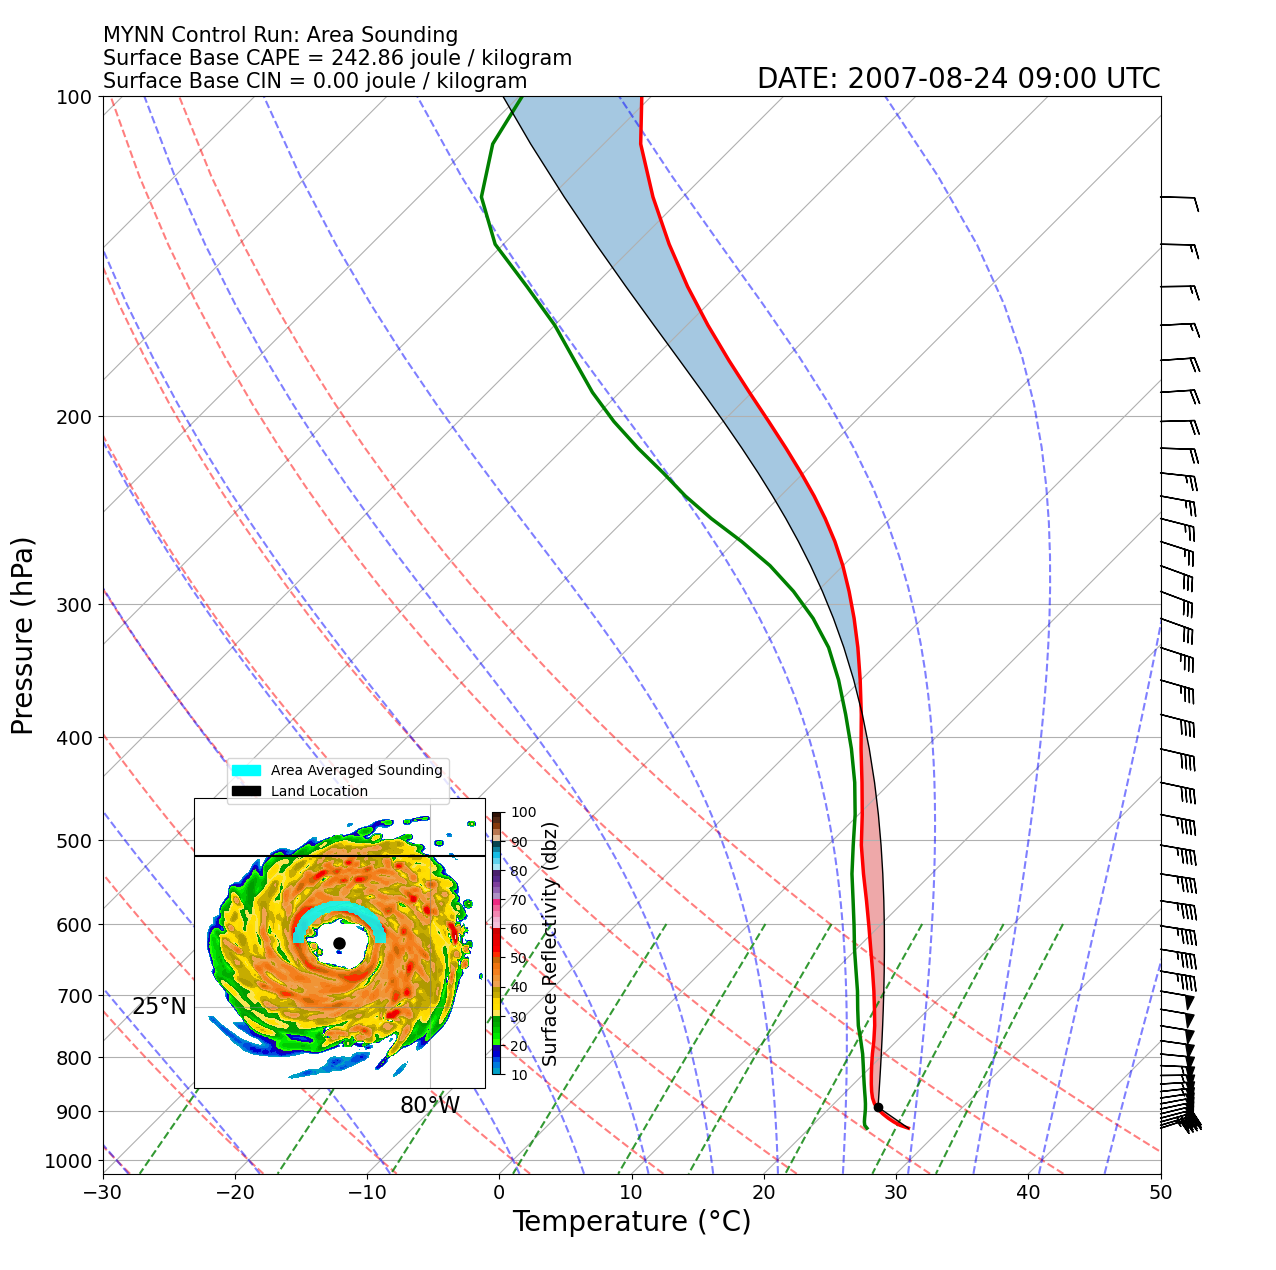

In [18]:
#for item in range(1,len(datafiles_wrfout),3):
for item in range(51,52,2):
    ncfile = Dataset(datafiles_1[item])
    wrf_out_data = xr.open_dataset(datafiles_1[item])
    
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    
    #Set up one time string for plot titles, another for file names
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime, titletime, timestr)
    
    #Get constant variables
    lat = getvar(ncfile, "XLAT")
    lon = getvar(ncfile, "XLONG")
    land = wrf_out_data['LANDMASK'][0,:,:].values
    ny, nx = lat.shape
    ###############################################################################################
    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    #Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    
    #print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values
    ##############################################################################################
    #IR brightness temperature
    wrf_out_OLR =  wrf_out_data['OLR'][0,:,:]
    wrf_out_OLR_T = -273.15 + (wrf_out_OLR.values + 310)/2

    #for boundary layer stuff
    pblh = wrf_out_data['PBLH'][0,:,:]
    f    = wrf_out_data['F'][0,:,:]
    ##############################################################################################
    #Initialize subset arrays with zero values. Start with field variables, then diagnostics
    wgrd, ugrd, vgrd, pgrd, tvgrd, wind_abs, rho = [np.zeros([ny,nx,n_zlevs]) for _ in range(7)]  #Range is just the number of variables specified to the left
    
    #Get variables 
    z_height = getvar(ncfile, "z")
    #p = getvar(ncfile, "pres")
    ua = getvar(ncfile, "ua")
    va = getvar(ncfile, "va")
    #wa = getvar(ncfile, "wa")
    #tv = getvar(ncfile, "tv")
    
    for k in range(n_zlevs):
        clev = zlevs[k]
        
        #Do vertical interpolation to specified vertical surfaces (in m)
        #wap = interplevel(wa, z_height, clev)
        uap = interplevel(ua, z_height, clev)
        vap = interplevel(va, z_height, clev)
        #pap = interplevel(p, z_height, clev)
        #tvp = interplevel(tv, z_height, clev)
    
        #wgrd[:,:,k]  = wap[:,:]
        ugrd[:,:,k]  = uap[:,:]
        vgrd[:,:,k]  = vap[:,:]
        #pgrd[:,:,k]  = pap[:,:]
        #tvgrd[:,:,k]  = tvp[:,:]
        wind_abs[:,:,k] = np.sqrt(uap[:,:]**2 + vap[:,:]**2)

    #Hello there cameron, we are doing stupid math again
    #pgrd_pa = pgrd[:,:,:] 
    #rho = pgrd_pa / (rd * tvgrd[:,:,:])
    ##############################################################################################
    #woooo, we get to make more lists yaaayyyyyy
    ydist, xdist, tcdist, rlonfac, theta_ang = [np.zeros([ny,nx]) for _ in range(5)]
    u_radial, v_azimuth                      = [np.zeros([ny,nx,n_zlevs]) for _ in range(2)]
   
    #compute distance from each grid point to storm center
    rlonfac[:,:] = 111000.*np.cos(d2r*lat[:,:])
    ydist[:,:]   = (lat[:,:] - lat[ypos,xpos])*111000
    xdist[:,:]   = (lon[:,:] - (lon[ypos,xpos]))*rlonfac
    tcdist[:,:]  = (xdist[:,:]**2 + ydist[:,:]**2)**0.5
    
    #calculate angle
    theta_ang = np.arctan2(ydist, xdist)
    angles_deg = np.degrees(theta_ang) % 360
    
    #Pre-calculate cos and sin of theta_ang for use in vectorized calculations
    cos_theta = np.cos(theta_ang)
    sin_theta = np.sin(theta_ang)
    ##############################################################################################
    #Azimuthal average by binning.  Need to specify grid point of storm center, and have arrays for lat, lon
    #Could also set up to specify lat/lon of storm center
    binnum  = 63     #this lets us look at 250 kilometers away from the TC center
    binsize = 1
    dx      = 4000.   #Horizontal grid size of our domain
    
    xlabs = ['']*binnum

    pvbin, wabin, windbin           = [np.zeros([ny,nx]) for _ in range(3)]
    pvazavg, waazavg, windzavg      = [np.zeros([n_zlevs-1,int(binnum/binsize)]) for _ in range(3)]
    
    for j in range (0, binnum, binsize):
        binmin = j*dx
        binmax = (j+binsize)*dx
        bincnt = int(j/binsize)
        
        xlabs[j] = str(bincnt*12)
        for k in range (1, n_zlevs-1):
            pvbin[:,:] = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), u_radial[:,:,k], np.nan)
            windbin[:,:] = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), wind_abs[:,:,k], np.nan)
            
            pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
            windzavg[k,bincnt] = np.nanmean(windbin[:,:])
    ##############################################################################################
    #now determine where the RMW is:
    
    #Initialize variable to store maximum wind and corresponding level and radius
    overall_max_wind = -np.inf
    rmw_level = -1
    rmw_radius = -1
    
    #Loop through each vertical level
    for k in range(1, n_zlevs-1):
        # Check if the current level slice has any non-NaN values
        if np.isnan(windzavg[k, :]).all():
            print(f"Level {k} has all NaN values; skipping this level.")
            continue  # Skip this iteration if all values are NaN
    
        #Find the index of the maximum value in the windzavg array for this level
        max_wind_index = np.nanargmax(windzavg[k, :])
        max_wind_value = windzavg[k, max_wind_index]
    
        #Check if this is the overall maximum wind so far
        if max_wind_value > overall_max_wind:
            overall_max_wind = max_wind_value
            rmw_level = k
            rmw_radius = max_wind_index * binsize * dx / 1000.  # Convert meters to kilometers
    
    #Print the overall RMW details
    if rmw_level != -1:
        print(f"The RMW occurs at level {rmw_level}, at a radius of {rmw_radius:.2f} km, with a maximum wind of {overall_max_wind:.2f} m/s")
    else:
        print("No valid maximum wind found across all levels.")
    ##############################################################################################
    #User-specified radius in kilometers
    inner_radius_km = rmw_radius
    outer_radius_km = rmw_radius + 25
    
    #Convert km to meters
    inner_radius_m = inner_radius_km * 1000
    outer_radius_m = outer_radius_km * 1000

    print(inner_radius_m, outer_radius_m)
    
    #Calculate angles in radians from the storm center to each point, and convert to degrees
    angles_rad = theta_ang
    angles_deg = angles_deg

    #Define a mask for the specific radius and tolerance
    radius_mask_annular = (tcdist >= inner_radius_m) & (tcdist <= outer_radius_m) & (angles_deg >= 0) & (angles_deg <= 180)

    #Convert the boolean mask to a numeric array (0 for False, 1 for True)
    masked_values = np.where(radius_mask_annular, 1, np.nan)

    ##############################################################################################
    #Get pertinent values necessary for skew-T
    p1      = wrf.getvar(ncfile,"pressure",timeidx=0)     #Pressure
    T1      = wrf.getvar(ncfile,"tc",timeidx=0)           #Temperature
    Td1     = wrf.getvar(ncfile,"td",timeidx=0)           #Dewpoint
    u1      = wrf.getvar(ncfile,"ua",timeidx=0)           #Zonal Winds
    v1      = wrf.getvar(ncfile,"va",timeidx=0)           #Meridional Winds
    pot1    = wrf.getvar(ncfile,"th",timeidx=0)           #Potential Temperature
    height1 = wrf.getvar(ncfile,"height_agl",timeidx=0)   #Height above ground level for mass point

    #Convert xarray DataArrays to numpy arrays
    p1_np = p1.values
    T1_np = T1.values
    Td1_np = Td1.values
    u1_np = u1.values
    v1_np = v1.values
    height1_np = height1.values
    
    #Expand the mask to match the 3D array shape
    #expanded_mask = masked_values[np.newaxis, :, :]
    print(np.shape(p1_np))
    height =  np.shape(p1_np)[0] 

    # Initialize arrays to store the averages for each vertical level
    p_avg = np.zeros(height)
    T_avg = np.zeros(height)
    Td_avg = np.zeros(height)
    u_avg = np.zeros(height)
    v_avg = np.zeros(height)
    height_avg = np.zeros(height)
    
    # Loop through each vertical level
    for k in range(height):
        p_masked      = np.where(masked_values == 1, p1_np[k, :, :], np.nan)
        T_masked      = np.where(masked_values == 1, T1_np[k, :, :], np.nan)
        Td_masked     = np.where(masked_values == 1, Td1_np[k, :, :], np.nan)
        u_masked      = np.where(masked_values == 1, u1_np[k, :, :], np.nan)
        v_masked      = np.where(masked_values == 1, v1_np[k, :, :], np.nan)
        height_masked = np.where(masked_values == 1, height1_np[k, :, :], np.nan)
    
        #Compute averages for each vertical level, ignoring NaNs
        p_avg[k] = np.nanmean(p_masked)
        T_avg[k] = np.nanmean(T_masked)
        Td_avg[k] = np.nanmean(Td_masked)
        u_avg[k] = np.nanmean(u_masked)
        v_avg[k] = np.nanmean(v_masked)
        height_avg[k] = np.nanmean(height_masked)

    #print(p_avg[0])
    print(T_avg)
    print(Td_avg)
    
    #Assign correct units to the averaged variables for the first valid index
    p_first_valid = p_avg[0] * units.hPa
    T_first_valid = T_avg[0] * units.degC
    Td_first_valid = Td_avg[0] * units.degC

    # alculate the LCL (Lifted Condensation Level) using the valid data point
    lcl_pressure, lcl_temperature = mpcalc.lcl(p_first_valid, T_first_valid, Td_first_valid)

    #Assign units to the entire profile for the parcel profile calculation
    p_avg_units = p_avg * units.hPa  # Pressure in hPa
    T_avg_units = T_avg * units.degC  # Temperature in Celsius
    Td_avg_units = Td_avg * units.degC  # Dewpoint in Celsius

    # print(p_avg_units)
    
    #Calculate the parcel profile
    prof = mpcalc.parcel_profile(p_avg_units,  T_first_valid, Td_first_valid) 
    prof = prof.to('degC')  #Convert the profile to Celsius for plotting
    
    #MetPy skew-T plotting
    fig = plt.figure(figsize = (14,14))
    skew = SkewT(fig, rotation = 45)
    ax1 = skew
    ax1.plot(p_avg, T_avg, 'r', linewidth = 2.5)
    ax1.plot(p_avg, Td_avg, 'g', linewidth = 2.5)
    
    #Specify Range Below for your plot
    ax1.ax.set_ylim(1030,100)
    ax1.ax.set_xlim(-30,50)
    
    #Plot the LCL point
    ax1.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
    
    #Plot the parcel profile with temperature units
    ax1.plot(p_avg, prof.magnitude, 'k', linewidth=1)
    
    #Shade CAPE using the profile with units
    ax1.shade_cape(p_avg_units, T_avg_units, prof)
    ax1.shade_cin(p_avg_units, T_avg_units, prof)
    
    #Surface-based CAPE and CIN calculations
    cape_cin = mpcalc.cape_cin(p_avg_units, T_avg_units, Td_avg_units, prof)
    
    # #Plot wind barbs
    ax1.plot_barbs(p_avg[:-5], u_avg[:-5], v_avg[:-5])
    
    #Add adiabats, mixing lines, and adjust labels
    ax1.plot_dry_adiabats()
    ax1.plot_moist_adiabats()
    ax1.plot_mixing_lines()
    
    ax1.ax.tick_params(axis='both', which='major', labelsize=14)
    ax1.ax.set_xlabel("Temperature (°C)", fontsize=20)
    ax1.ax.set_ylabel("Pressure (hPa)", fontsize=20)
    
    # Add titles
    plt.title(f'DATE: {titletime} UTC', loc='right', fontsize=20)

    plt.title(f'MYNN Control Run: Area Sounding\nSurface Base CAPE = {cape_cin[0]:.2f}\nSurface Base CIN = {-cape_cin[1]:.2f}', 
              loc='left', fontsize=15)
    #######################################################################################################
    #Next for valdiation purposes, show the approximate area of the sounding via the code above
    ax2 = fig.add_axes([0.2, 0.15, 0.25, 0.25], projection=ccrs.PlateCarree())  #Specify the location
    tclon5a=5*(int(tc_lon/5)-1)
    tclon5b=5*(int(tc_lon/5))
    tclat5a=5*(int(tc_lat/5)-1)
    tclat5b=5*(int(tc_lat/5))
       
    ax2.set_extent([tc_lon-3, tc_lon+3, tc_lat-3, tc_lat+3],ccrs.PlateCarree()) #Constrain FOV of plot
    gl = ax2.gridlines(color='gray',alpha=0.5,draw_labels=True)
    gl.top_labels = False    #This turns off the top labels
    gl.right_labels = False  #This turns off the right labels
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([tclon5a-10, tclon5a-5, tclon5a, tclon5b, tclon5b+5, tclon5b+10])
    gl.ylocator = mticker.FixedLocator([tclat5a-10, tclat5a-5, tclat5a, tclat5b, tclat5b+5, tclat5b+10])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax2.xaxis.set_major_formatter(gl.xformatter)
    ax2.yaxis.set_major_formatter(gl.yformatter)

    dbz = getvar(ncfile,"dbz")
    dbz = dbz[0]
    Terrain_height = wrf_out_data['LANDMASK'][0,:,:].values

    #Plot for ax2
    plot = ax2.contourf(lon, lat,  dbz,
                origin = 'lower',
                colors = reflectivity_colors2, 
                levels = levels, 
                alpha = 1,
                zorder = 1)
    
    cbar = plt.colorbar(plot, orientation = 'vertical', pad = .02, shrink = .75, aspect = 30, extend = 'both')
    cbar.ax.set_ylabel('Surface Reflectivity (dbz)', fontsize = 14)

    ax2.contour(lon.values, lat.values, Terrain_height, 
                        origin = 'lower', 
                        colors = 'black', 
                        levels = np.arange(-1, 2, 1))
    
    ax2.plot(tc_lon, tc_lat, 'ko', markersize=8, label='Storm Center')
    
    ax2.contourf(lon.values, lat.values, masked_values,
                 origin = 'lower', 
                 colors = 'cyan', 
                 alpha = .85,
                 zorder = 10)

    #Manually create a proxy artist for the legend
    cyan_patch = mpatches.Patch(color='cyan', label='Area Averaged Sounding')
    land_patch = mpatches.Patch(color='black', label='Land Location')

    #Add the legend to the plot
    ax2.legend(handles=[cyan_patch, land_patch], bbox_to_anchor=(.4, .66, 0.5, 0.5))

    plt.show()
    plt.close()